In [90]:
import pystan as ps
import arviz as az
import numpy as np
import json
from scipy.special import expit

In [121]:
model = """
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (sum(ldet_terms) - (phit_D * phi - alpha * (phit_W * phi)));
  }
}
data {
  int<lower = 1> n;
  int<lower = 1> p;
  matrix[n, p] X;
  int<lower = 0> y[n];
  matrix<lower = 0, upper = 1>[n, n] W; // adjacency matrix
  int W_n;                // number of adjacent region pairs
}
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
parameters {
  vector[p] beta;
  vector[n] phi;
  real<lower = 0> tau;
  real<lower = 0, upper = 1> alpha;
}
transformed parameters {
    real<lower = 0> sigma = (1/sqrt(tau));
}
model {
  phi ~ sparse_car(alpha, W_sparse, D_sparse, lambda, n, W_n);
  beta ~ normal(0, 1);
  tau ~ gamma(2, 2);
  y ~ bernoulli_logit(X * beta + sigma * phi);
}
"""

## Fake data

In [98]:
n = 50
p = 2
X = np.random.multivariate_normal(mean = np.zeros(p), 
                                  cov = np.eye(p), 
                                  size = n)

beta = np.random.uniform(-3,3, size = (p,1))

W = np.zeros((n,n))
for i in range(n-1):
    for j in range(i+1,n):
        if np.random.random() < 0.1: 
            W[i,j] = 1
            W[j,i] = 1
    c = np.random.choice(range(i+1, n))
    W[i,c] = 1
    W[c,i] = 1

W_n = int(W.sum()//2)

tau = 1
rho = 0.5
D = np.diag(W.sum(axis = 1))

phi = np.random.multivariate_normal(mean = np.zeros(n), 
                                    cov = (1/tau) * np.linalg.inv(D - rho * W)).reshape(-1,1)

prev = 0.1
logit_prev = np.log(prev / (1 - prev))

y = np.random.binomial(n =1, p = expit(X@beta + phi))# + logit_prev))

In [99]:
data = {
  "n": n,
  "p": p,
  "X": X, 
  "y": y.flatten(),
  "W": W, 
  "W_n": W_n,
}

In [122]:
sm = ps.StanModel(model_code = model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_97bcf6cdceb1be0391f5fa26362dbb1a NOW.


In [123]:
fit = sm.sampling(data = data, iter = 5000, 
                  pars = ('beta', 'tau', 'alpha'))

array([[<AxesSubplot:ylabel='beta\n1'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='tau'>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='beta\n0', ylabel='alpha'>,
        <AxesSubplot:xlabel='beta\n1'>, <AxesSubplot:xlabel='tau'>]],
      dtype=object)

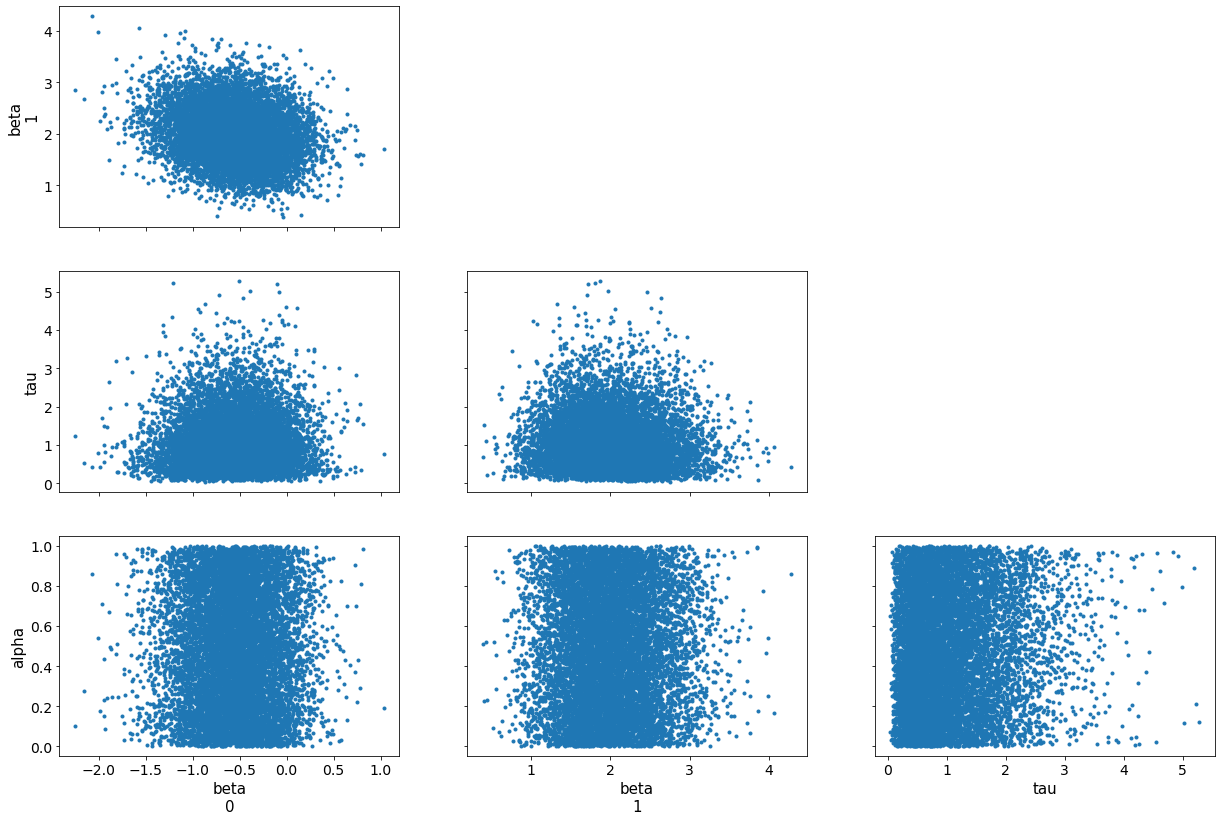

In [124]:
az.plot_pair(fit)

array([<AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'beta\n1'}>,
       <AxesSubplot:title={'center':'tau'}>,
       <AxesSubplot:title={'center':'alpha'}>], dtype=object)

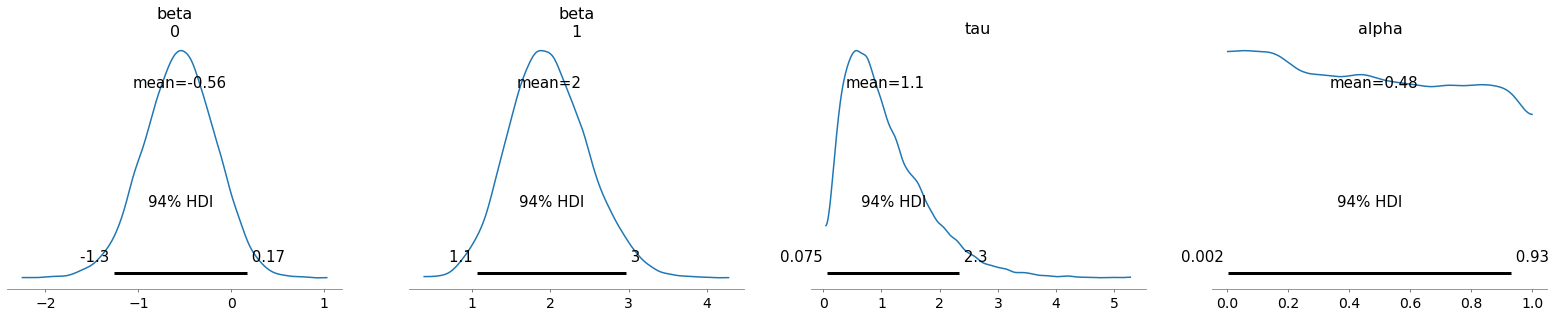

In [125]:
az.plot_posterior(fit)

array([[<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>]], dtype=object)

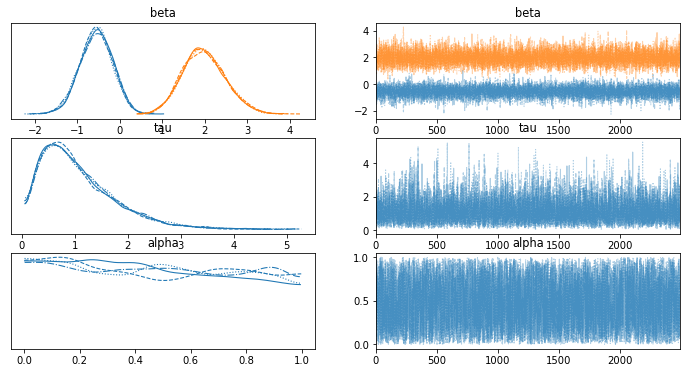

In [126]:
az.plot_trace(fit)